---
title: State Estimation - Weak Constrained 4DVar
subject: Modern 4DVar
subtitle: How to estimate the state using a dynamical ODE
short_title: State Est. - Weak
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    GP: Gaussian Process
---

In [1]:
import os, sys

jaxsw_path = "/Users/eman/code_projects/jaxsw"
sys.path.append(jaxsw_path)

In [10]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr
import functools as ft

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

jax.config.update("jax_enable_x64", True)

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [11]:
ds_sol = xr.open_dataset("./data/sim_l63.nc")
ds_sol

<xarray.Dataset>
Dimensions:              (time: 200, component: 3, realization: 1000)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation           (component, realization, time) float32 ...
    observations         (component, realization, time) float32 ...
    observations_noise   (component, realization, time) float64 ...
    observations_interp  (component, realization, time) float64 ...

## Inverse Problem

In [12]:
realization = 100

ds_trajectory = ds_sol.sel(realization=realization)
ds_trajectory

<xarray.Dataset>
Dimensions:              (time: 200, component: 3)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Data variables:
    simulation           (component, time) float32 ...
    observations         (component, time) float32 ...
    observations_noise   (component, time) float64 ...
    observations_interp  (component, time) float64 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


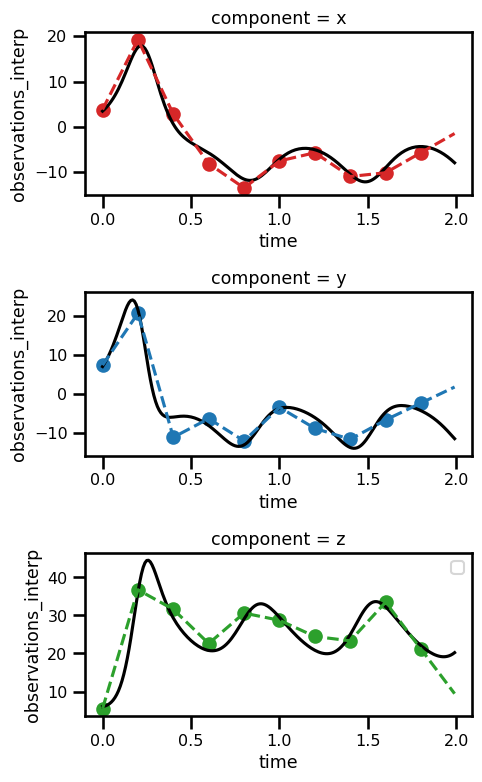

In [13]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))


ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

ds_trajectory.observations_noise.sel(component="x").plot.scatter(
    ax=ax[0], color="tab:red"
)
ds_trajectory.observations_noise.sel(component="y").plot.scatter(
    ax=ax[1], color="tab:blue"
)
ds_trajectory.observations_noise.sel(component="z").plot.scatter(
    ax=ax[2], color="tab:green"
)

ds_trajectory.observations_interp.sel(component="x").plot(
    ax=ax[0], color="tab:red", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="y").plot(
    ax=ax[1], color="tab:blue", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="z").plot(
    ax=ax[2], color="tab:green", linestyle="--"
)

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

## Data

For this problem we need the following variables

**True State**: $\boldsymbol{u}$

**Time Steps**: $\boldsymbol{\Tau}$

**Observations**: $\boldsymbol{y}$

**Initial State**: $\boldsymbol{u}^{(k)}$

**Mask**: $\boldsymbol{m}$

In [23]:
# Ground Truth
x_state = jnp.asarray(ds_trajectory.simulation.values).T.astype(jnp.float64)
ts_state = jnp.asarray(ds_trajectory.time.values).astype(jnp.float64)
# Observations
y_gt = jnp.asarray(ds_trajectory.observations_noise.values).T.astype(jnp.float64)
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_trajectory.observations_noise.values))
    .astype(jnp.float32)
    .T.astype(jnp.float64)
)
# initialization
x_init = jnp.asarray(ds_trajectory.observations_interp.values).T.astype(jnp.float64)

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((200, 3), (200, 3), (200, 3), (200, 3))

## Dynamical Prior

Here, we define our dynamical prior which we plug into this loss function.

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
||\boldsymbol{u} - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$

Our dynamical prior in this case is defined by:

$$
\boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta}) \coloneqq
\boldsymbol{u}(t_1) =
\boldsymbol{u}(t_0) + \int_{t_0}^{t_1}
\boldsymbol{F}\left( \boldsymbol{u}(t),\tau;\boldsymbol{\theta}\right)d\tau 
$$



**Weak Constrained**

The weak-constrained version works as a "one-step" prediction whereby we step through the trajectory with the ODE solver one at a time.


$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
$$

In [24]:
from mfourdvar._src.priors.dynamical import DynIncrements, DynTrajectory
from jaxsw import L63State, L63Params

In [25]:
import typing as tp
from jaxtyping import Array, PyTree

class L63Params(eqx.Module):
    sigma: Array = eqx.static_field()
    rho: Array = eqx.static_field()
    beta: Array = eqx.static_field()
    
    def __init__(self, sigma: float=10., rho: float=28., beta: float=2.667):
        self.sigma = jnp.asarray(sigma, dtype=jnp.float64)
        self.rho = jnp.asarray(rho, dtype=jnp.float64)
        self.beta = jnp.asarray(beta, dtype=jnp.float64)

class L63Model(eqx.Module):
    model: PyTree

    def init_state(self, x: PyTree) -> PyTree:
        state = L63State(
            x=jnp.atleast_1d(x[..., 0]), 
            y=jnp.atleast_1d(x[..., 1]), 
            z=jnp.atleast_1d(x[..., 2])
        )
        return state
    
    def __call__(self, t, state, args):
        return self.model.equation_of_motion(t, state, args)

In [26]:
# init dynamical system
l63_dyn_model = Lorenz63()

# initialize prior model
prior_model = L63Model(model=l63_dyn_model)


# initialize state
state_init = prior_model.init_state(x_init)

# initialize params
params = L63Params(sigma=10., rho=28., beta=2.667)


# output state
state_out = prior_model(0, state_init, params)

# check input and output are the same
assert state_init.x.shape == state_out.x.shape
assert state_init.y.shape == state_out.y.shape
assert state_init.z.shape == state_out.z.shape

In [27]:
# initialize dynamical prior
prior = DynIncrements(model=prior_model, params=params)

In [37]:
from mfourdvar._src.utils import time_patches
ts_patches = time_patches(ts_state)
out = jax.vmap(prior, in_axes=(0,0), out_axes=(0))(x_init[:-1], ts_patches)
out.array.shape, out.y.shape

((199, 3), (199, 1, 1))

#### Sanity Check

In this sanity check, we're going to compare two losses:
a) one set of inputs will be the true state propagated through the 1 step ODE model and
b) one loss of inputs will be the state initialized via the naive interpolation scheme.

In prinicpal, the absolute loss value should be **more** for the state initialized with the naive interpolation.

In [40]:
loss_true = prior.loss(x=x_state, ts=ts_state)

loss_init = prior.loss(x=x_init, ts=ts_state)

loss_init_state = prior.loss(x=x_init, ts=ts_state, x_gt=x_state)

# check hypothesis
assertion = loss_init > loss_true

msg = f"Loss\n----"
msg = f""
msg += f"\nInit+True State: {loss_init:.2f}"
print(
    f"Loss\n----"+
    f"\nTrue State: {loss_true:.2f}" +
    f"\nInit State: {loss_init:.2f}" +
    f"\nInit+True State: {loss_init_state:.2f}" +
    f"\nLess: {assertion}"
)

Loss
----
True State: 0.00
Init State: 137.11
Init+True State: 6027.93
Less: True


We see that this is the case!

**Note**: The loss is not exactly zero as one might initially suspect.
However, this may be the case because we are stepping iteratively one-step at a time instead of simply predicting using the full trajectory.
This may have some accumulated error somewhere in these many steps.

### Learning

In this instance, we're going to use a simple gradient descent scheme.

$$
\boldsymbol{u}^{(k+1)} =
\boldsymbol{u}^{(k)} +
\alpha \boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

where $\alpha$ is the learning rate and $\boldsymbol{\nabla_u}$ is the gradient operator wrt the state, $\boldsymbol{u}$.
We have an optimality condition of the gradient of the variational cost.

$$
\boldsymbol{F_g}(\boldsymbol{u};\boldsymbol{\theta}) =
\boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

Because we are doing gradient *descent*, we will use a negative learning rate of $\alpha=-0.1$.

For this first part, we're simply going to use the variational cost as the dynamical prior.

$$
\begin{aligned}
\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta}) &=
\boldsymbol{R}(\boldsymbol{u};\boldsymbol{\theta}) \\
&=
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
\end{aligned}
$$

In [41]:
# create grad loss function
grad_loss_fn = jax.jit(jax.value_and_grad(prior.loss, has_aux=False))

In [42]:
from tqdm.autonotebook import trange

losses = []
num_iterations = 30_000
learning_rate = - 0.2
x = x_init.copy()
# # x_gt = x_init
# x_gt = x_state.copy()

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:

        # get dynamical loss + gradient
        loss, x_grad = grad_loss_fn(x, ts_state)

        pbar.set_description(f"Loss: {loss:.2e}")
        losses.append(loss)

        # clip gradients
        x_grad = jnp.clip(x_grad, a_min=-1.0, a_max=1.0)

        # update solution with gradient
        x += learning_rate * x_grad

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_3433/2452222050.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


  0%|          | 0/30000 [00:00<?, ?it/s]

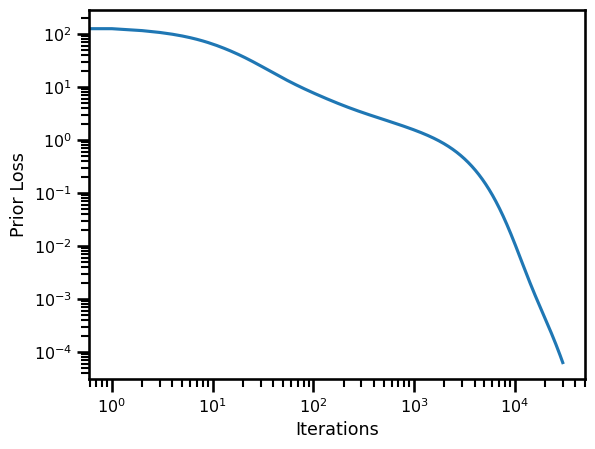

In [43]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(
    yscale="log", 
    xscale="log",
    xlabel="Iterations", 
    ylabel="Prior Loss"
)
plt.show()

In [44]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float64 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float64 3.636 4.008 4.417 ... 18.19 18.35
    state           (component, time) float64 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float64 3.834 4.606 5.379 ... 10.05 9.436
    observation     (component, time) float64 3.834 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


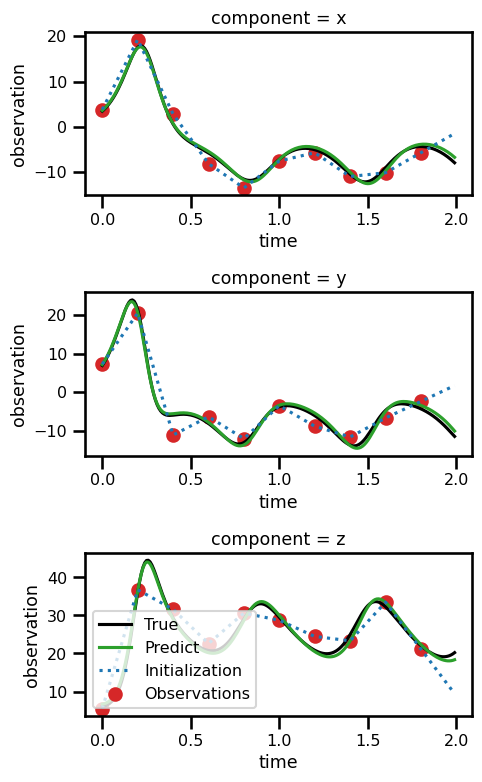

In [45]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    plt.legend()


# plt.legend()
plt.tight_layout()
plt.show()

## Observation Operator

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{H}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$


We can use a simpler loss function which is just a masking operator.

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{u}||_{\Omega_{obs}}^2
$$

where $\Omega_{obs}$ is the domain of the observation.

In [47]:
from mfourdvar._src.operators.base import ObsOperator

obs_operator = ObsOperator()

obs_operator.loss(x_init, y_gt, y_mask)

Array(0., dtype=float64)

## Variational Cost

In [51]:
from mfourdvar._src.varcost.dynamical import WeakVarCost

In [52]:
# compute initial condition
x = x_init.copy()
x_gt = x_state.copy()

# init dynamical system
l63_dyn_model = Lorenz63()

# initialize prior model
prior_model = L63Model(model=l63_dyn_model)
# initialize params
params = L63Params(sigma=10., rho=28., beta=2.667)
# initialize dynamical prior
prior = DynIncrements(model=prior_model, params=params)

# initialize observation operator
obs_operator = ObsOperator()

# initialize variational cost function
prior_weight = 0.9
obs_op_weight = 0.05
background_weight = 0.05
varcost_fn = WeakVarCost(
    prior=prior, 
    obs_op=obs_operator, 
    prior_weight=prior_weight, 
    obs_op_weight=obs_op_weight, 
    background_weight=background_weight
)


# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state, ts=ts_state, y=y_gt,  x_gt=x_state, mask=y_mask, return_loss=True)
loss_init_true, losses_init_true = varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  x_gt=x_state, mask=y_mask, return_loss=True)

In [53]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)
print("Init X vs True State")
print(losses_init_true)

True State vs True State
{'var_loss': Array(5.17501827, dtype=float64), 'prior': Array(2.11213048e-06, dtype=float64), 'obs': Array(103.50032733, dtype=float64), 'bg': Array(5.17501827, dtype=float64)}
Init X vs Init State
{'var_loss': Array(123.39489731, dtype=float64), 'prior': Array(137.10544146, dtype=float64), 'obs': Array(0., dtype=float64), 'bg': Array(123.39489731, dtype=float64)}
Init X vs True State
{'var_loss': Array(5425.14077045, dtype=float64), 'prior': Array(6027.93418939, dtype=float64), 'obs': Array(0., dtype=float64), 'bg': Array(5425.14077045, dtype=float64)}


### Learning

In [55]:
import functools as ft


@ft.partial(jax.value_and_grad, has_aux=True)
def loss_function_state(x_init):    
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt, mask=y_mask, xb=x_state[0], return_loss=True)

(loss, _), grads = loss_function_state(x_init)
print(grads.shape)

@eqx.filter_value_and_grad(has_aux=True)
def loss_function_state(x_init):    
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt, mask=y_mask, xb=x_state[0], return_loss=True)

(loss, _), grads = loss_function_state(x_init)
print(grads.shape)


(200, 3)
(200, 3)


In [63]:
from tqdm.autonotebook import trange

losses = dict(prior=[], obs=[], bg=[], var_loss=[])
num_iterations = 2_000
learning_rate = - 0.2
x = x_init.copy()

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:

        # get dynamical loss + gradient
        (_, loss), x_grad = loss_function_state(x)

        losses["var_loss"].append(loss["var_loss"])
        losses["prior"].append(loss["prior"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Prior - {loss['prior']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # clip gradients
        x_grad = jnp.clip(x_grad, a_min=-1.0, a_max=1.0)

        # update solution with gradient
        x += learning_rate * x_grad

  0%|          | 0/2000 [00:00<?, ?it/s]

In [64]:
# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state, ts=ts_state, y=y_gt,  x_gt=x_state, mask=y_mask, return_loss=True)
loss_init_true, losses_init_true = varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  x_gt=x_state, mask=y_mask, return_loss=True)
loss_sol_true, losses_sol_true = varcost_fn.loss(x=x, ts=ts_state, y=y_gt,  x_gt=x_state, mask=y_mask, return_loss=True)
loss_sol, losses_sol = varcost_fn.loss(x=x, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)

In [65]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)
print("Init X vs True State")
print(losses_init_true)
print("Sol State vs True State")
print(losses_sol_true)
print("Sol state")
print(losses_sol)

True State vs True State
{'var_loss': Array(5.17501827, dtype=float64), 'prior': Array(2.11213048e-06, dtype=float64), 'obs': Array(103.50032733, dtype=float64), 'bg': Array(5.17501827, dtype=float64)}
Init X vs Init State
{'var_loss': Array(123.39489731, dtype=float64), 'prior': Array(137.10544146, dtype=float64), 'obs': Array(0., dtype=float64), 'bg': Array(123.39489731, dtype=float64)}
Init X vs True State
{'var_loss': Array(5425.14077045, dtype=float64), 'prior': Array(6027.93418939, dtype=float64), 'obs': Array(0., dtype=float64), 'bg': Array(5425.14077045, dtype=float64)}
Sol State vs True State
{'var_loss': Array(906.05181181, dtype=float64), 'prior': Array(1004.14436518, dtype=float64), 'obs': Array(46.43766306, dtype=float64), 'bg': Array(906.05181181, dtype=float64)}
Sol state
{'var_loss': Array(3.37225144, dtype=float64), 'prior': Array(1.16707587, dtype=float64), 'obs': Array(46.43766306, dtype=float64), 'bg': Array(3.37225144, dtype=float64)}


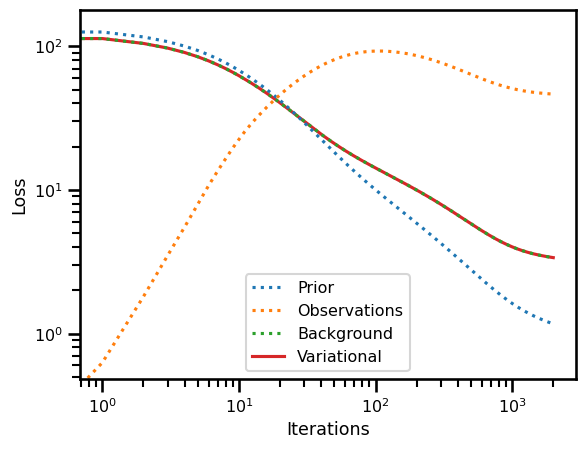

In [66]:
fig, ax = plt.subplots()

ax.plot(losses["prior"], label="Prior", linestyle=":")
ax.plot(losses["obs"], label="Observations", linestyle=":")
ax.plot(losses["bg"], label="Background", linestyle=":")
ax.plot(losses["var_loss"], label="Variational", zorder=0)

ax.set(
    yscale="log",
    xscale="log",
    xlabel="Iterations", 
    ylabel="Loss"
)

plt.legend()
plt.show()

In [67]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float64 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float64 3.562 3.918 4.316 ... 15.55 15.39
    state           (component, time) float64 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float64 3.834 4.606 5.379 ... 10.05 9.436
    observation     (component, time) float64 3.834 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


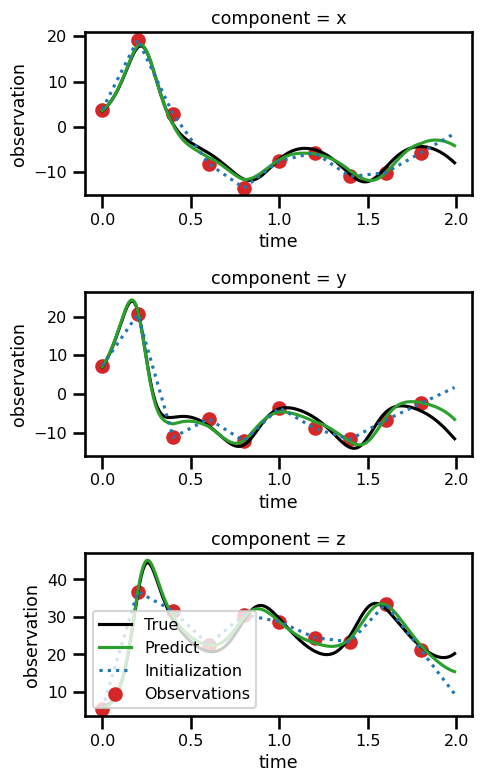

In [68]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    plt.legend()


# plt.legend()
plt.tight_layout()
plt.show()